# Connecting Kaggle and Google Drive

In [2]:
from google.colab import files

In [ ]:
!pip install -q kaggle
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/100-bird-species/
!unzip 100-bird-species.zip;

# Importing Libraries

In [6]:
import os
import cv2
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from pathlib import Path
import seaborn as sns
# PYTORCH IMPORTS
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
# SCI-KIT LEARN IMPORTS
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# TENSORFLOW IMPORTS FOR TRANSFER LEARNING
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

DIR_TRAIN = "/content/train/"
DIR_VALID = "/content/valid/"
DIR_TEST = "/content/test/"

# Understanding Data and Data Preprocessing

In [7]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir(DIR_TRAIN)
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join(DIR_TRAIN, _class)
    valid_dir = os.path.join(DIR_VALID, _class)
    test_dir = os.path.join(DIR_TEST, _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

Total Classes: 525
Total train images: 84635
Total valid images: 2620
Total test images: 2625


In [10]:
import os
import cv2
import random
def get_top_species(dataset_dir, num_species):
    species_count = {}
    for species in os.listdir(dataset_dir):
        species_dir = os.path.join(dataset_dir, species)
        if os.path.isdir(species_dir):
            species_count[species] = len(os.listdir(species_dir))
    top_species = sorted(species_count, reverse=True)[:num_species]
    return top_species

def process_and_save_images(dataset_dir, train_dir, valid_dir, test_dir, top_species, num_images_per_species, is_grayscale=True):
    for save_dir in [train_dir, valid_dir, test_dir]:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    for species in top_species:
        species_dir = os.path.join(dataset_dir, species)
        all_images = os.listdir(species_dir)
        random.shuffle(all_images)

        train_images = all_images[:num_images_per_species]
        remaining_images = all_images[num_images_per_species:]
        split_point = len(remaining_images) // 2
        valid_images = remaining_images[:split_point]
        test_images = remaining_images[split_point:]

        for img_set, save_dir in zip([train_images, valid_images, test_images], [train_dir, valid_dir, test_dir]):
            species_save_dir = os.path.join(save_dir, species)
            if not os.path.exists(species_save_dir):
                os.makedirs(species_save_dir)

            for img_name in img_set:
                img_path = os.path.join(species_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if is_grayscale else cv2.IMREAD_COLOR)
                save_path = os.path.join(species_save_dir, img_name)
                cv2.imwrite(save_path, img)

num_species = 10
num_images_per_species = 100  # Number of images per species for training
top_species = get_top_species('/content/train', num_species)

process_and_save_images('/content/train', '/content/gray_train','/content/gray_valid','/content/gray_test', top_species, num_images_per_species, is_grayscale=True)
process_and_save_images('/content/train', '/content/RGB_train', '/content/RGB_valid','/content/RGB_test',top_species, num_images_per_species, is_grayscale=False)

In [11]:
num_of_bird_groups = len(os.listdir("/content/gray_train"))
num_of_bird_groups

10

# Data Augmentation

In [12]:
#DATA AUGMENTATION
# Augment images and save them to the disk
# Define the augmentation pipelines

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

valid_test_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

def augment_and_save_images(dataset_dir, save_dir, transform, multiply_factor):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for species in os.listdir(dataset_dir):
        species_dir = os.path.join(dataset_dir, species)
        species_save_dir = os.path.join(save_dir, species)
        if not os.path.exists(species_save_dir):
            os.makedirs(species_save_dir)

        for img_name in os.listdir(species_dir):
            img_path = os.path.join(species_dir, img_name)
            image = Image.open(img_path)

            for i in range(multiply_factor):
                img_tensor = transform(image)
                augmented_img = transforms.ToPILImage()(img_tensor)
                augmented_img.save(os.path.join(species_save_dir, f"{i}_{img_name}"))

augment_and_save_images("/content/RGB_train", "/content/aug_RGB_train", train_transforms, 5)
augment_and_save_images("/content/RGB_valid", "/content/aug_RGB_valid", valid_test_transforms, 5)
augment_and_save_images("/content/RGB_test", "/content/aug_RGB_test", valid_test_transforms, 5)
augment_and_save_images("/content/gray_train", "/content/aug_gray_train", train_transforms, 5)
augment_and_save_images("/content/gray_valid", "/content/aug_gray_valid", valid_test_transforms, 5)
augment_and_save_images("/content/gray_test", "/content/aug_gray_test", valid_test_transforms, 5)

In [13]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir("/content/RGB_train")
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join("/content/RGB_train", _class)
    valid_dir = os.path.join("/content/RGB_valid", _class)
    test_dir = os.path.join("/content/RGB_test", _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))
    else:
        print(f"Warning: Training directory does not exist: {train_dir}")

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))
    else:
        print(f"Warning: Validation directory does not exist: {valid_dir}")

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))
    else:
        print(f"Warning: Test directory does not exist: {test_dir}")

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

Total Classes: 10
Total train images: 1000
Total valid images: 401
Total test images: 406


In [14]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir("/content/RGB_train")
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join("/content/aug_RGB_train", _class)
    valid_dir = os.path.join("/content/aug_RGB_valid", _class)
    test_dir = os.path.join("/content/aug_RGB_test", _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))
    else:
        print(f"Warning: Training directory does not exist: {train_dir}")

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))
    else:
        print(f"Warning: Validation directory does not exist: {valid_dir}")

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))
    else:
        print(f"Warning: Test directory does not exist: {test_dir}")

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

Total Classes: 10
Total train images: 5000
Total valid images: 2005
Total test images: 2030


# CNN Model

Initializing the dataset.

In [29]:
class BirdDataset(Dataset):
    def __init__(self, root_dir):
        class_names = os.listdir(root_dir)
        self.class_list = []
        self.image_path_list = []

        for class_id, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)
            image_paths = [os.path.join(class_dir, image_file) for image_file in image_files]
            self.image_path_list.extend(image_paths)
            self.class_list.extend([class_id]*len(image_paths))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, data_id):
        image_path = self.image_path_list[data_id]
        image_class = self.class_list[data_id]
        image = Image.open(image_path)
        image_tensor = self.transform(image)
        return image_class, image_tensor

In [30]:
train_dataset = BirdDataset(root_dir='/content/aug_RGB_train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = BirdDataset(root_dir='/content/RGB_valid')
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = BirdDataset(root_dir='/content/RGB_test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [31]:
random.seed(464)

In [40]:
#MODEL 1
import torch.nn as nn
import torch.nn.functional as F

class BirdCNN(nn.Module):
    def __init__(self):
        super(BirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64*28*28, out_features=128),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_block_1(x)  # Bx3x224x224 --> Bx16x112x112
        x = self.conv_block_2(x)  # Bx16x112x112 --> Bx32x56x56
        x = self.conv_block_3(x)  # Bx32x56x56 --> Bx64x28x28
        x = self.flatten(x)       # Bx64x28x28 --> Bx50176
        x = self.fc_layers(x)     # Bx50176 --> Bx128 --> Bx64 --> Bx10
        x = self.sigmoid(x)
        return x


In [41]:
#MODEL 2
import torch.nn as nn
import torch.nn.functional as F

class AlternativeBirdCNN(nn.Module):
    def __init__(self):
        super(AlternativeBirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256 * 14 * 14, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        x = self.softmax(x)
        return x

In [55]:
#MODEL 3

import torch.nn as nn
import torch.nn.functional as F

class ModifiedBirdCNN(nn.Module):
    def __init__(self):
        super(ModifiedBirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)

        # Global Average Pooling
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)

        x = self.fc_layers(x)
        return x



In [51]:
# Check if a GPU is available and move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedBirdCNN().to(device)
loss_func = nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
model = ModifiedBirdCNN()  # Instantiate the improved model

loss_func = nn.CrossEntropyLoss()  # CrossEntropyLoss is appropriate for multi-class classification
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
#TRAINING WITH LOCAL GPU

from tqdm import tqdm

# Modify the data loading to move batches to the same device as the model
num_batches = len(train_dataloader)
num_epochs = 15
iter_losses = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress", total=num_epochs, position=0, leave=True):
    total_iter_loss = 0.0
    for image_class_batch, image_tensor_batch in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
        # Move data to the same device as the model
        if torch.cuda.is_available():
            image_tensor_batch, image_class_batch = image_tensor_batch.to(device), image_class_batch.to(device)
            model.cuda()
        optimizer.zero_grad()
        batch_output = model(image_tensor_batch)
        loss = loss_func(batch_output, image_class_batch)
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        total_iter_loss += loss.item()
    epoch_loss = total_iter_loss / num_batches
    epoch_losses.append(epoch_loss)
    print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

print("Training is finished!")

Training Progress:   7%|▋         | 1/15 [00:16<03:46, 16.18s/it]


Epoch 1 Loss: 1.989232431484174


Training Progress:  13%|█▎        | 2/15 [00:32<03:31, 16.25s/it]


Epoch 2 Loss: 1.6403515203089654


Training Progress:  20%|██        | 3/15 [00:49<03:16, 16.38s/it]


Epoch 3 Loss: 1.3971584793887561


Training Progress:  27%|██▋       | 4/15 [01:05<02:58, 16.25s/it]


Epoch 4 Loss: 1.221116239511514


Training Progress:  33%|███▎      | 5/15 [01:20<02:39, 15.97s/it]


Epoch 5 Loss: 1.0825410145747512


Training Progress:  40%|████      | 6/15 [01:36<02:23, 15.91s/it]


Epoch 6 Loss: 0.9769577949861937


Training Progress:  47%|████▋     | 7/15 [01:54<02:12, 16.58s/it]


Epoch 7 Loss: 0.8846802477595173


Training Progress:  53%|█████▎    | 8/15 [02:11<01:56, 16.65s/it]


Epoch 8 Loss: 0.8043642783466773


Training Progress:  60%|██████    | 9/15 [02:27<01:38, 16.46s/it]


Epoch 9 Loss: 0.741560303712193


Training Progress:  67%|██████▋   | 10/15 [02:42<01:20, 16.19s/it]


Epoch 10 Loss: 0.6877452648138698


Training Progress:  73%|███████▎  | 11/15 [02:58<01:04, 16.03s/it]


Epoch 11 Loss: 0.6457600352130358


Training Progress:  80%|████████  | 12/15 [03:14<00:47, 15.93s/it]


Epoch 12 Loss: 0.6191039266465586


Training Progress:  87%|████████▋ | 13/15 [03:29<00:31, 15.90s/it]


Epoch 13 Loss: 0.5779749728456328


Training Progress:  93%|█████████▎| 14/15 [03:45<00:15, 15.94s/it]


Epoch 14 Loss: 0.5473416492908816


Training Progress: 100%|██████████| 15/15 [04:01<00:00, 16.13s/it]


Epoch 15 Loss: 0.5212604350681547
Training is finished!


In [62]:
from tqdm import tqdm

num_batches = len(train_dataloader)
num_epochs = 15
iter_losses = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress", total=num_epochs, position=0, leave=True):
    total_iter_loss = 0.0
    for image_class_batch, image_tensor_batch in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
        optimizer.zero_grad()
         # Move data to the same device as the model
        if torch.cuda.is_available():
            image_tensor_batch, image_class_batch = image_tensor_batch.to(device), image_class_batch.to(device)
            model.cuda()
        batch_output = model(image_tensor_batch)
        loss = loss_func(batch_output, image_class_batch)
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        total_iter_loss += loss.item()
    epoch_loss = total_iter_loss / num_batches
    epoch_losses.append(epoch_loss)
    print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

print("Training is finished!")

Training Progress:   7%|▋         | 1/15 [00:15<03:42, 15.87s/it]


Epoch 1 Loss: 0.5209113480169562


Training Progress:  13%|█▎        | 2/15 [00:31<03:20, 15.45s/it]


Epoch 2 Loss: 0.4701514078091972


Training Progress:  20%|██        | 3/15 [00:46<03:04, 15.34s/it]


Epoch 3 Loss: 0.4432414026954506


Training Progress:  27%|██▋       | 4/15 [01:01<02:49, 15.37s/it]


Epoch 4 Loss: 0.4316806378243845


Training Progress:  33%|███▎      | 5/15 [01:17<02:34, 15.42s/it]


Epoch 5 Loss: 0.3888152245479294


Training Progress:  40%|████      | 6/15 [01:32<02:18, 15.39s/it]


Epoch 6 Loss: 0.39939214609846285


Training Progress:  47%|████▋     | 7/15 [01:47<02:02, 15.35s/it]


Epoch 7 Loss: 0.38444573630260515


Training Progress:  53%|█████▎    | 8/15 [02:02<01:47, 15.29s/it]


Epoch 8 Loss: 0.35041907806939715


Training Progress:  60%|██████    | 9/15 [02:18<01:31, 15.30s/it]


Epoch 9 Loss: 0.3281903510229497


Training Progress:  67%|██████▋   | 10/15 [02:34<01:17, 15.53s/it]


Epoch 10 Loss: 0.32733704394932034


Training Progress:  73%|███████▎  | 11/15 [02:49<01:01, 15.49s/it]


Epoch 11 Loss: 0.32799331296848344


Training Progress:  80%|████████  | 12/15 [03:04<00:46, 15.39s/it]


Epoch 12 Loss: 0.32397133376024945


Training Progress:  87%|████████▋ | 13/15 [03:20<00:30, 15.33s/it]


Epoch 13 Loss: 0.32883382824402824


Training Progress:  93%|█████████▎| 14/15 [03:35<00:15, 15.46s/it]


Epoch 14 Loss: 0.28172139898885656


Training Progress: 100%|██████████| 15/15 [03:51<00:00, 15.40s/it]


Epoch 15 Loss: 0.2578462550911722
Training is finished!


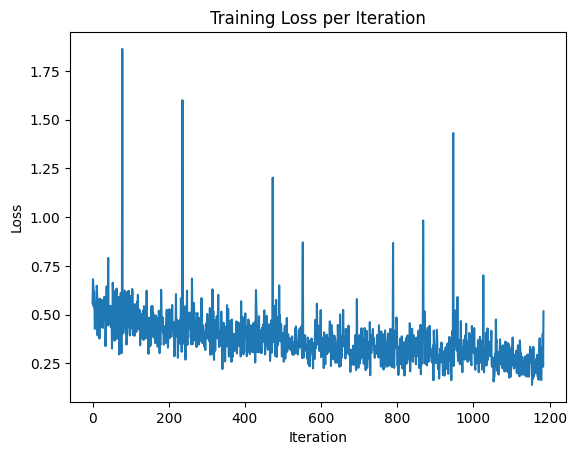

In [63]:
plt.plot(range(len(iter_losses)), iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.show()

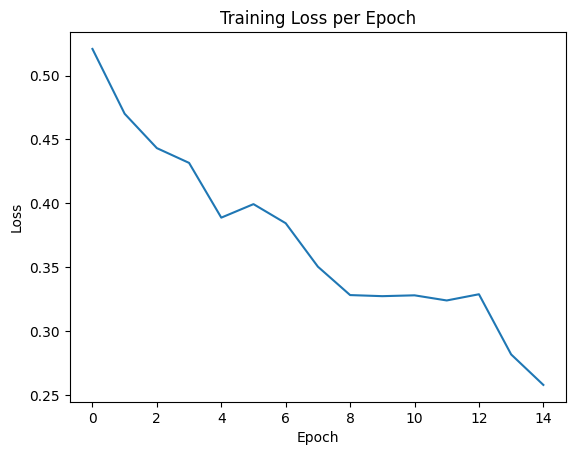

In [64]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

In [65]:
#EVALUATION IN LOCAL GPU

model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for batch_image_class, batch_image_tensor in val_dataloader:
        # Move data to the same device as the model
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)


        batch_outputs = model(batch_image_tensor)

        # Use torch.argmax instead of np.argmax
        pred_classes = torch.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum().item()

        pred_class_list.extend(list(pred_classes.cpu().numpy()))
        gt_class_list.extend(list(batch_image_class.cpu().numpy()))

    print("Validation Accuracy: {:.2%}".format(num_pred_correct / num_pred_total))

Validation Accuracy: 80.55%


In [66]:
model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

with torch.no_grad():
    for batch_image_class, batch_image_tensor in val_dataloader:
        batch_outputs = model(batch_image_tensor)

        batch_image_class = batch_image_class.numpy()
        batch_outputs = batch_outputs.cpu().numpy()
        pred_classes = np.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum()

        pred_class_list.extend(list(pred_classes))
        gt_class_list.extend(list(batch_image_class))

    print("Validation Accuracy: {}".format(num_pred_correct / num_pred_total))

Validation Accuracy: 0.8054862842892768


<Axes: >

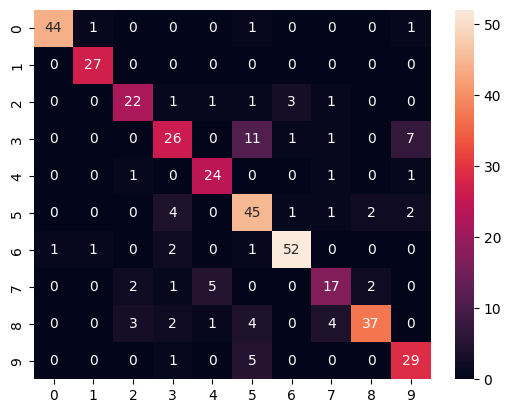

In [67]:
num_classes = 10
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)
for sample_id in range(len(gt_class_list)):
    pred_class = pred_class_list[sample_id]
    gt_class = gt_class_list[sample_id]
    confusion_matrix[gt_class, pred_class] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [68]:
#TEST EVALUATION IN LOCAL GPU

model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for batch_image_class, batch_image_tensor in test_dataloader:
        # Move data to the same device as the model
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)


        batch_outputs = model(batch_image_tensor)

        # Use torch.argmax instead of np.argmax
        pred_classes = torch.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum().item()

        pred_class_list.extend(list(pred_classes.cpu().numpy()))
        gt_class_list.extend(list(batch_image_class.cpu().numpy()))

    print("Test Accuracy: {:.2%}".format(num_pred_correct / num_pred_total))

Test Accuracy: 80.54%


<Axes: >

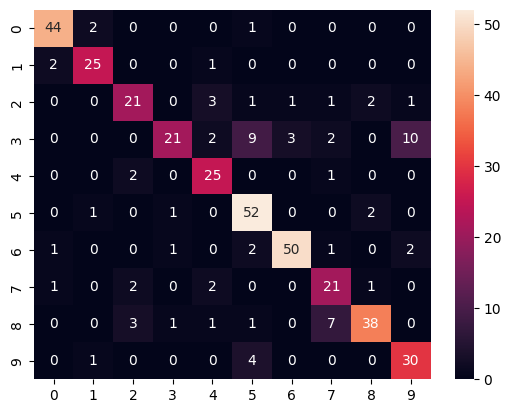

In [69]:
num_classes = 10
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)
for sample_id in range(len(gt_class_list)):
    pred_class = pred_class_list[sample_id]
    gt_class = gt_class_list[sample_id]
    confusion_matrix[gt_class, pred_class] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d")

# EfficientNet-B0


In [85]:
def data_generators(train_path, valid_path, test_path, batch_size = 16, target_size = (224, 224)):
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
  valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical"
  )

  valid_generator = valid_datagen.flow_from_directory(
      valid_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical"
  )

  test_generator = test_datagen.flow_from_directory(
      test_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical",
      shuffle=False
  )
  return train_generator, valid_generator, test_generator



def apply_transfer_learning(base_model, base_model_type, train_path, valid_path, test_path):
  for layer in base_model.layers:
      layer.trainable = False
  checkpoint_cb = ModelCheckpoint(
      'model.h5',  # Path where to save the model
      save_best_only=True,        # Save only the best model
      monitor='val_accuracy',     # Performance metric to monitor
      mode='max',                 # Mode for the monitored metric ('max' for accuracy)
      verbose=1                   # Verbosity level
    )
  early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',    # Performance metric to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                  # Verbosity level
  )

  X = base_model.output
  X = GlobalAveragePooling2D()(X)
  if (base_model_type ==  "efficientnetb0"):
    X = Dense(10, activation = "softmax")(X)
    model = Model(inputs = base_model.input, outputs = X) # <- our model to be trained
  elif (base_model_type == "resnet50"):
    X = Dense(1024, activation = "relu")(X) # <- add a fully connected layer
    predictions = Dense(10, activation = "softmax")(X) # <- add a 10-class softmax layer at the end
    model = Model(inputs = base_model.input, outputs = predictions) # <- our model to be trained


  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  train_generator, valid_generator, test_generator = data_generators( train_path, valid_path, test_path)
  history = model.fit(
                      train_generator,
                      epochs = 10,
                      validation_data = valid_generator,
                      callbacks=[checkpoint_cb, early_stopping_cb]
                       )
  test_loss, test_accuracy = model.evaluate(test_generator)
  true_classes = test_generator.classes
  predicted_classes = make_inference(model, test_generator)
  cm = confusion_matrix(true_classes, predicted_classes)
  sns.heatmap(cm, annot = True)
  return history,test_loss, test_accuracy

def plot_history(history, title, data_type, is_aug = False):
  # Plotting training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  if is_aug:
    plt.title(f"Model accuracy for {title} Model with Augmented {data_type} Data")
  else:
    plt.title(f"Model accuracy for {title} Model with Not Augmented {data_type} Data")

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plotting training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  if is_aug:
    plt.title(f"Model loss for {title} Model with Augmented {data_type} Data")
  else:
    plt.title(f"Model loss for {title} Model with Not Augmented {data_type} Data")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


def make_inference(model, test_generator):

    test_generator.reset()

    # Make predictions
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_classes = np.argmax(predictions, axis=1)
    class_indices = test_generator.class_indices
    predicted_classes = np.argmax(predictions, axis = 1)

    return predicted_classes



In [77]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix


Found 1000 images belonging to 10 classes.
Found 401 images belonging to 10 classes.
Found 406 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.9683 - accuracy: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.98504, saving model to model.h5
63/63 [==============================] - 12s 82ms/step - loss: 0.9683 - accuracy: 0.8200 - val_loss: 0.3132 - val_accuracy: 0.9850
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9910
Epoch 2: val_accuracy improved from 0.98504 to 0.98753, saving model to model.h5
63/63 [==============================] - 4s 56ms/step - loss: 0.2193 - accuracy: 0.9910 - val_loss: 0.1502 - val_accuracy: 0.9875
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9910
Epoch 3: val_accuracy did not improve from 0.98753
63/63 [==============================] - 3s 49ms/step - loss: 0.1179 - accuracy: 0.9910 - val_loss: 0.1021 - val_accurac

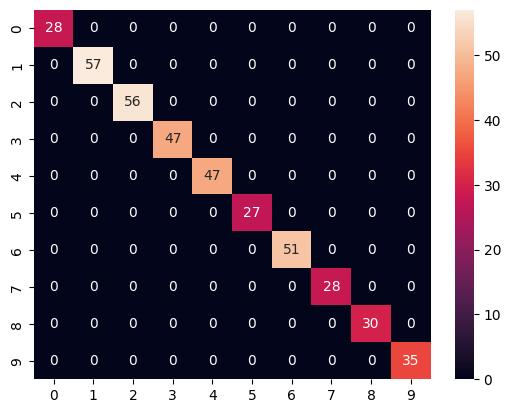

In [78]:
history_rgb, test_loss_rgb, test_accuracy_rgb = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)),
    "efficientnetb0", "/content/RGB_train", "/content/RGB_valid", "/content/RGB_test")


Found 1000 images belonging to 10 classes.
Found 401 images belonging to 10 classes.
Found 406 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 1.0752 - accuracy: 0.7570
Epoch 1: val_accuracy improved from -inf to 0.93017, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 12s 83ms/step - loss: 1.0752 - accuracy: 0.7570 - val_loss: 0.4762 - val_accuracy: 0.9302
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.9530
Epoch 2: val_accuracy improved from 0.93017 to 0.96010, saving model to model.h5
63/63 [==============================] - 4s 58ms/step - loss: 0.3440 - accuracy: 0.9530 - val_loss: 0.2729 - val_accuracy: 0.9601
Epoch 3/10
62/63 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.96010 to 0.96259, saving model to model.h5
63/63 [==============================] - 4s 57ms/step - loss: 0.2020 - accuracy: 0.9790 - val_loss: 0.2004 - val_accuracy: 0.9626
Epoch 4/10
62/63 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9807
Epoch 4: val_accuracy improved from 0.96259 to 0.97007, saving model to model.h5
63/63 [==============================] - 4s 57ms/step - loss: 0.1469 - accuracy: 0.9

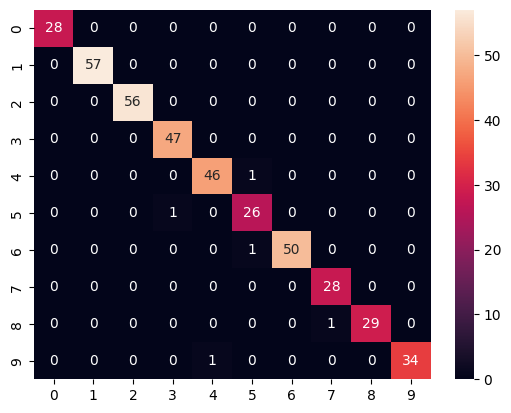

In [79]:
history_gray, test_loss_gray, test_accuracy_gray = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/gray_train", "/content/gray_valid", "/content/gray_test")

Found 5000 images belonging to 10 classes.
Found 2005 images belonging to 10 classes.
Found 2030 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.9538
Epoch 1: val_accuracy improved from -inf to 0.98653, saving model to model.h5
313/313 [==============================] - 25s 59ms/step - loss: 0.3125 - accuracy: 0.9538 - val_loss: 0.0912 - val_accuracy: 0.9865
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9974
Epoch 2: val_accuracy improved from 0.98653 to 0.99002, saving model to model.h5
313/313 [==============================] - 17s 53ms/step - loss: 0.0429 - accuracy: 0.9974 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9990
Epoch 3: val_accuracy improved from 0.99002 to 0.99202, saving model to model.h5
313/313 [==============================] - 16s 51ms/step - loss: 0.0206 - acc

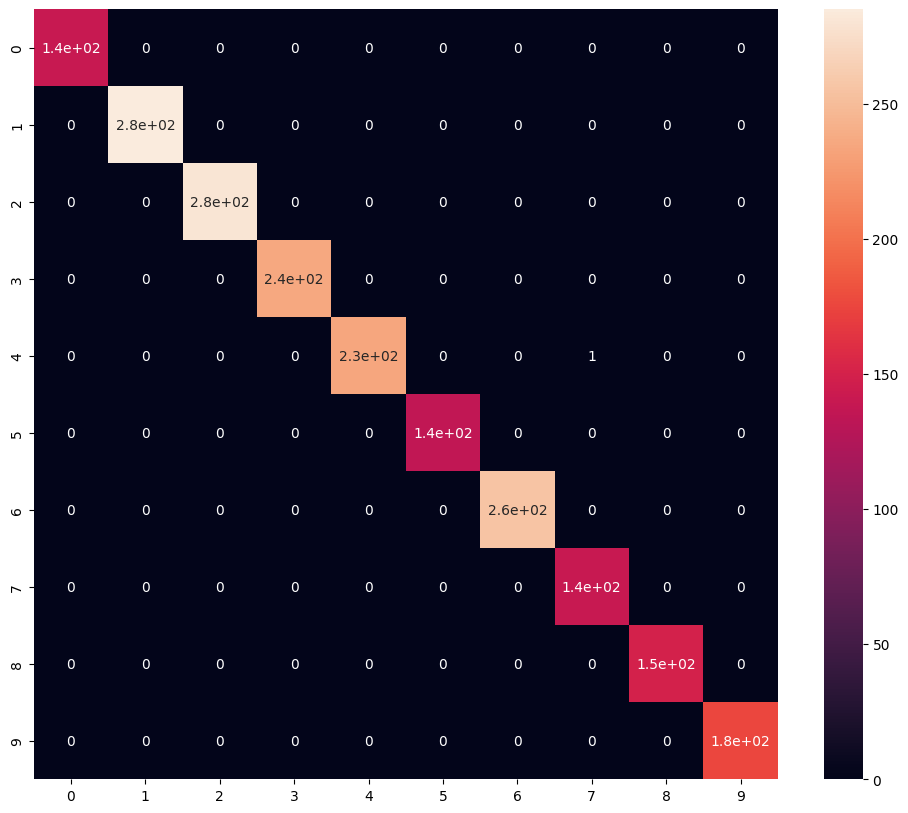

In [83]:
history_rgb_aug, test_loss_rgb_aug, test_accuracy_rgb_aug = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/aug_RGB_train", "/content/aug_RGB_valid", "/content/aug_RGB_test")

Found 5000 images belonging to 10 classes.
Found 2005 images belonging to 10 classes.
Found 2030 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.9070
Epoch 1: val_accuracy improved from -inf to 0.95461, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 26s 58ms/step - loss: 0.4553 - accuracy: 0.9070 - val_loss: 0.2068 - val_accuracy: 0.9546
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9868
Epoch 2: val_accuracy improved from 0.95461 to 0.96259, saving model to model.h5
313/313 [==============================] - 16s 51ms/step - loss: 0.1015 - accuracy: 0.9868 - val_loss: 0.1533 - val_accuracy: 0.9626
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9946
Epoch 3: val_accuracy improved from 0.96259 to 0.96409, saving model to model.h5
313/313 [==============================] - 16s 52ms/step - loss: 0.0582 - accuracy: 0.9946 - val_loss: 0.1351 - val_accuracy: 0.9641
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9972
Epoch 4: val_accuracy did not improve from 0.96409
313/313 [==============================] - 16s 50ms/step - loss: 0.0377 - accuracy: 0.9972 - val_los

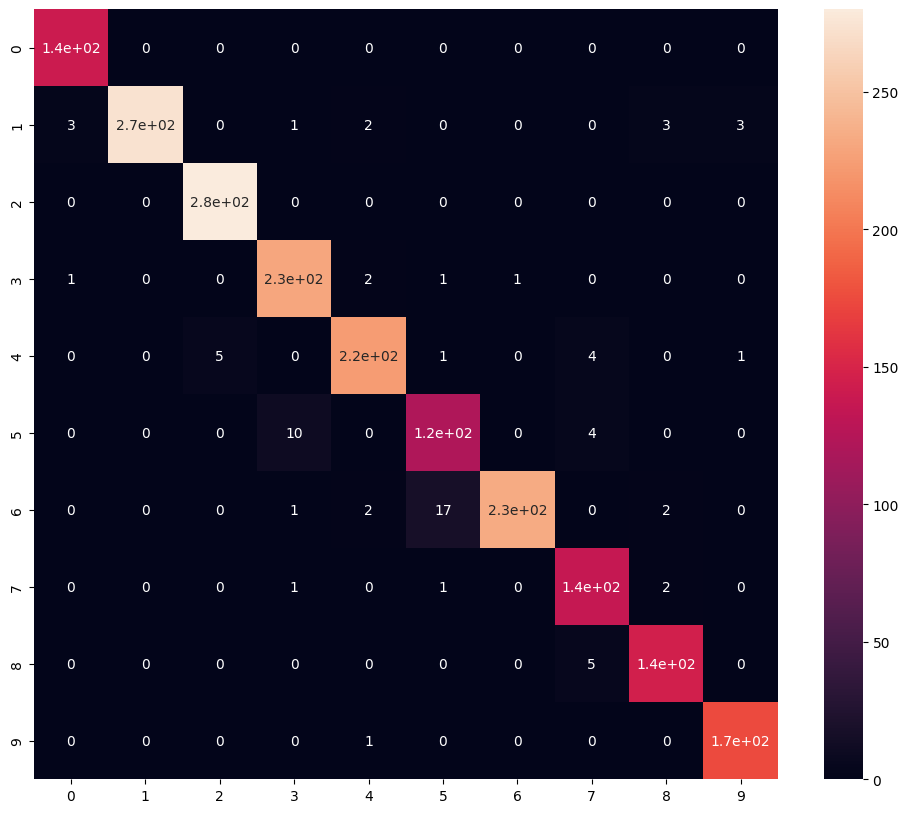

In [84]:
history_gray_aug, test_loss_gray_aug, test_accuracy_gray_aug = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/aug_gray_train", "/content/aug_gray_valid", "/content/aug_gray_test")

In [86]:
print(f"Test Accuracy for the EfficientNet-B0 Model with RGB Data {test_accuracy_rgb}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Grayscale Data {test_accuracy_gray}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Augmented RGB Data {test_accuracy_rgb_aug}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Augmented Grayscale Data {test_accuracy_gray_aug}")

Test Accuracy for the EfficientNet-B0 Model with RGB Data 1.0
Test Accuracy for the EfficientNet-B0 Model with Grayscale Data 0.9876847267150879
Test Accuracy for the EfficientNet-B0 Model with Augmented RGB Data 0.9995073676109314
Test Accuracy for the EfficientNet-B0 Model with Augmented Grayscale Data 0.9635468125343323


# ResNet50

94765736/94765736 [==============================] - 0s 0us/step
Found 1000 images belonging to 10 classes.
Found 401 images belonging to 10 classes.
Found 406 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.7800
Epoch 1: val_accuracy improved from -inf to 0.93766, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 15s 148ms/step - loss: 0.8669 - accuracy: 0.7800 - val_loss: 0.2189 - val_accuracy: 0.9377
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9800
Epoch 2: val_accuracy improved from 0.93766 to 0.97007, saving model to model.h5
63/63 [==============================] - 6s 99ms/step - loss: 0.0693 - accuracy: 0.9800 - val_loss: 0.0947 - val_accuracy: 0.9701
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9990
Epoch 3: val_accuracy did not improve from 0.97007
63/63 [==============================] - 5s 84ms/step - loss: 0.0126 - accuracy: 0.9990 - val_loss: 0.1248 - val_accuracy: 0.9601
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9990
Epoch 4: val_accuracy improved from 0.97007 to 0.97506, saving model to model.h5
63/63 [==============================] - 6s 98ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0889 - val_

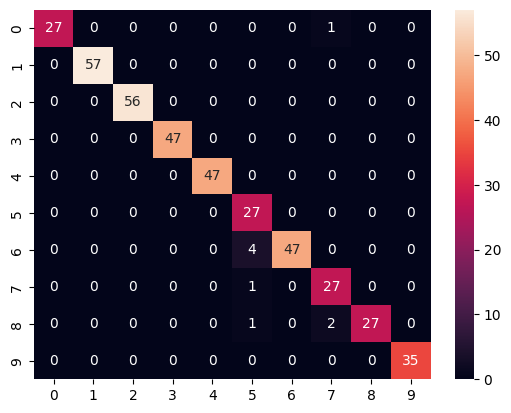

In [87]:
history_rgb, test_loss_rgb, test_accuracy_rgb = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)),
 "resnet50", "/content/RGB_train", "/content/RGB_valid", "/content/RGB_test")

Found 1000 images belonging to 10 classes.
Found 401 images belonging to 10 classes.
Found 406 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.9586 - accuracy: 0.7410
Epoch 1: val_accuracy improved from -inf to 0.88279, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 11s 122ms/step - loss: 0.9586 - accuracy: 0.7410 - val_loss: 0.4182 - val_accuracy: 0.8828
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9380
Epoch 2: val_accuracy improved from 0.88279 to 0.92519, saving model to model.h5
63/63 [==============================] - 6s 93ms/step - loss: 0.1838 - accuracy: 0.9380 - val_loss: 0.2589 - val_accuracy: 0.9252
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9890
Epoch 3: val_accuracy did not improve from 0.92519
63/63 [==============================] - 6s 101ms/step - loss: 0.0397 - accuracy: 0.9890 - val_loss: 0.3031 - val_accuracy: 0.8903
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9890
Epoch 4: val_accuracy improved from 0.92519 to 0.94264, saving model to model.h5
63/63 [==============================] - 6s 95ms/step - loss: 0.0425 - accuracy: 0.9890 - val_loss: 0.1767 - val

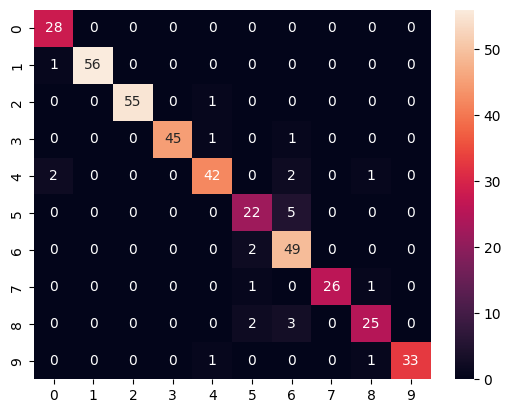

In [88]:
history_gray, test_loss_gray, test_accuracy_gray = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/gray_train", "/content/gray_valid", "/content/gray_test")


Found 5000 images belonging to 10 classes.
Found 2005 images belonging to 10 classes.
Found 2030 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9234
Epoch 1: val_accuracy improved from -inf to 0.93267, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 32s 92ms/step - loss: 0.2657 - accuracy: 0.9234 - val_loss: 0.2538 - val_accuracy: 0.9327
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9870
Epoch 2: val_accuracy did not improve from 0.93267
313/313 [==============================] - 26s 83ms/step - loss: 0.0382 - accuracy: 0.9870 - val_loss: 0.2965 - val_accuracy: 0.9292
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9920
Epoch 3: val_accuracy improved from 0.93267 to 0.94464, saving model to model.h5
313/313 [==============================] - 27s 85ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.2259 - val_accuracy: 0.9446
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9852
Epoch 4: val_accuracy did not improve from 0.94464
313/313 [==============================] - 26s 83ms/step - loss: 0.0554 - accuracy: 0.9852 - val_loss: 0.2769 - val_accuracy: 0.93

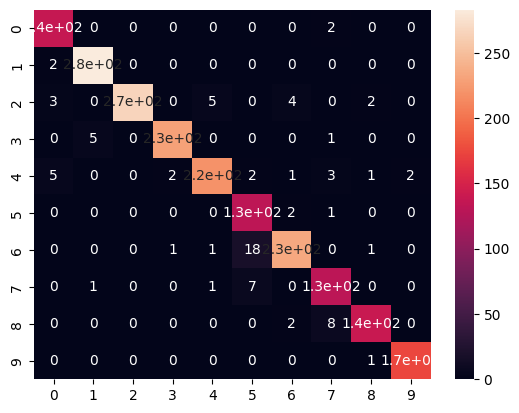

In [89]:
history_rgb_aug, test_loss_rgb_aug, test_accuracy_rgb_aug = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/aug_RGB_train", "/content/aug_RGB_valid", "/content/aug_RGB_test")

Found 5000 images belonging to 10 classes.
Found 2005 images belonging to 10 classes.
Found 2030 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8910
Epoch 1: val_accuracy improved from -inf to 0.85786, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 33s 91ms/step - loss: 0.4364 - accuracy: 0.8910 - val_loss: 0.4896 - val_accuracy: 0.8579
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9782
Epoch 2: val_accuracy improved from 0.85786 to 0.88678, saving model to model.h5
313/313 [==============================] - 27s 85ms/step - loss: 0.0633 - accuracy: 0.9782 - val_loss: 0.4468 - val_accuracy: 0.8868
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9812
Epoch 3: val_accuracy did not improve from 0.88678
313/313 [==============================] - 26s 83ms/step - loss: 0.0517 - accuracy: 0.9812 - val_loss: 0.5649 - val_accuracy: 0.8803
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9950
Epoch 4: val_accuracy improved from 0.88678 to 0.91771, saving model to model.h5
313/313 [==============================] - 27s 85ms/step - loss: 0.0159 - accuracy: 0.9950 - val_los

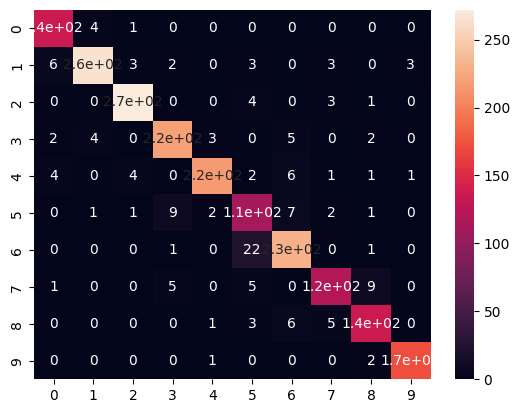

In [90]:
history_gray_aug, test_loss_gray_aug, test_accuracy_gray_aug = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/aug_gray_train", "/content/aug_gray_valid", "/content/aug_gray_test")

In [91]:
print(f"Test Accuracy for the ResNet50 Model with RGB Data {test_accuracy_rgb}")
print(f"Test Accuracy for the ResNet50 Model with Grayscale Data {test_accuracy_gray}")
print(f"Test Accuracy for the ResNet50 Model with Augmented RGB Data {test_accuracy_rgb_aug}")
print(f"Test Accuracy for the ResNet50 Model with Augmented Grayscale Data {test_accuracy_gray_aug}")

Test Accuracy for the ResNet50 Model with RGB Data 0.9778324961662292
Test Accuracy for the ResNet50 Model with Grayscale Data 0.9384236335754395
Test Accuracy for the ResNet50 Model with Augmented RGB Data 0.9586206674575806
Test Accuracy for the ResNet50 Model with Augmented Grayscale Data 0.9246305227279663


# Machine Learning Methods

Random Forest Classifier:
Accuracy: 0.3645320197044335
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.43      0.30        35
           1       0.44      0.57      0.49        30
           2       0.28      0.46      0.35        28
           3       0.52      0.45      0.48        51
           4       0.39      0.52      0.44        27
           5       0.20      0.15      0.17        47
           6       0.53      0.51      0.52        47
           7       0.40      0.30      0.34        56
           8       0.22      0.09      0.12        57
           9       0.42      0.46      0.44        28

    accuracy                           0.36       406
   macro avg       0.36      0.39      0.37       406
weighted avg       0.36      0.36      0.35       406



<Axes: >

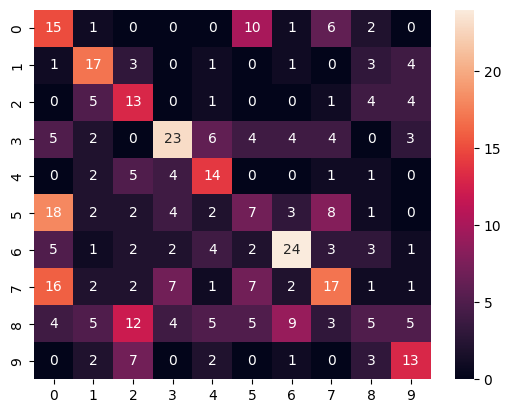

In [92]:
def prepare_data_and_labels(directory, species_list,img_size=(64,64)):
    data = []
    labels = []
    for label, bird in enumerate(species_list):
        bird_dir = os.path.join(directory, bird)
        for image in os.listdir(bird_dir):
            img_path = os.path.join(bird_dir, image)
            img = Image.open(img_path).resize(img_size)
            img_array = np.array(img).flatten()
            data.append(img_array)
            labels.append(label)
    return np.array(data), np.array(labels)

# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

# Train Random Forest Classifier
rf_classifier_augrgb = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_augrgb.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_augrgb.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

In these models, we have chosen the best parameters based on the validation set, and reported the test accuracy on the test set at the end.





Training with RGB images

# Random Forest

Random Forest Classifier:
Accuracy: 0.45320197044334976
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.49      0.35        35
           1       0.42      0.47      0.44        30
           2       0.32      0.54      0.40        28
           3       0.56      0.47      0.51        51
           4       0.44      0.56      0.49        27
           5       0.34      0.23      0.28        47
           6       0.73      0.74      0.74        47
           7       0.45      0.38      0.41        56
           8       0.57      0.30      0.39        57
           9       0.48      0.54      0.51        28

    accuracy                           0.45       406
   macro avg       0.46      0.47      0.45       406
weighted avg       0.48      0.45      0.45       406



<Axes: >

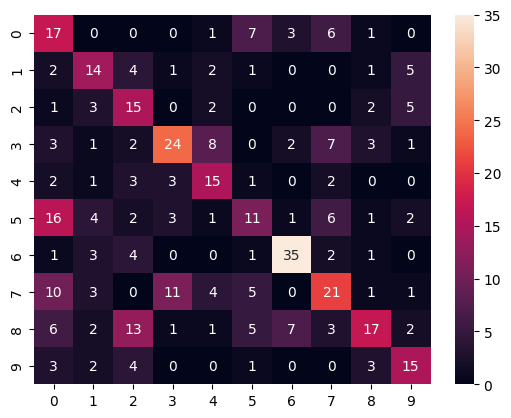

In [93]:
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

# Train Random Forest Classifier
rf_classifier_rgb = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_rgb.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_rgb.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

Training with Gray images

Random Forest Classifier:
Accuracy: 0.3103448275862069
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.20      0.15        35
           1       0.47      0.47      0.47        30
           2       0.29      0.54      0.37        28
           3       0.31      0.29      0.30        51
           4       0.24      0.33      0.28        27
           5       0.24      0.21      0.22        47
           6       0.55      0.49      0.52        47
           7       0.29      0.20      0.23        56
           8       0.34      0.18      0.23        57
           9       0.43      0.43      0.43        28

    accuracy                           0.31       406
   macro avg       0.33      0.33      0.32       406
weighted avg       0.33      0.31      0.31       406



<Axes: >

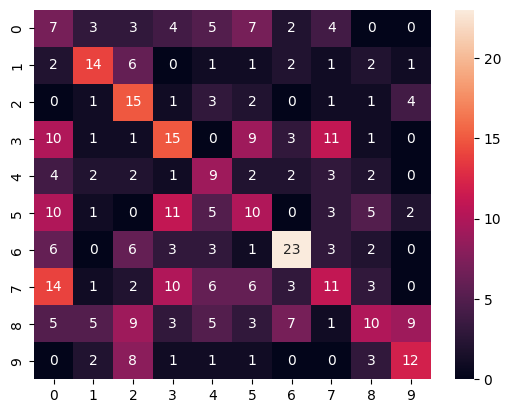

In [94]:
X_train, y_train = prepare_data_and_labels("/content/gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

# Train Random Forest Classifier
rf_classifier_gray = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_gray.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_gray.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

Training with Augmented Gray images

Random Forest Classifier:
Accuracy: 0.3497536945812808
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.43      0.29        35
           1       0.44      0.60      0.51        30
           2       0.33      0.57      0.42        28
           3       0.23      0.20      0.21        51
           4       0.20      0.26      0.23        27
           5       0.31      0.21      0.25        47
           6       0.60      0.53      0.56        47
           7       0.36      0.27      0.31        56
           8       0.52      0.23      0.32        57
           9       0.46      0.46      0.46        28

    accuracy                           0.35       406
   macro avg       0.37      0.38      0.36       406
weighted avg       0.38      0.35      0.35       406



<Axes: >

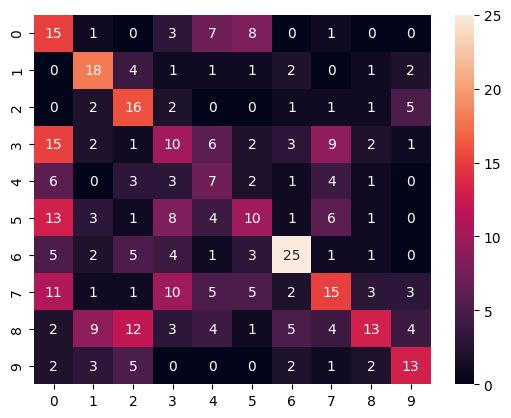

In [95]:
X_train, y_train = prepare_data_and_labels("/content/aug_gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

# Train Random Forest Classifier
rf_classifier_auggray = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_auggray.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_auggray.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

# Multinomial Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Multinomial Logistic Regression Classifier:
Accuracy: 0.5911330049261084
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.49      0.47        35
           1       0.59      0.67      0.62        30
           2       0.43      0.46      0.45        28
           3       0.74      0.76      0.75        51
           4       0.53      0.85      0.66        27
           5       0.39      0.30      0.34        47
           6       0.80      0.74      0.77        47
           7       0.57      0.55      0.56        56
           8       0.65      0.46      0.54        57
           9       0.65      0.79      0.71        28

    accuracy                           0.59       406
   macro avg       0.58      0.61      0.59       406
weighted avg       0.59      0.59      0.59       406



<Axes: >

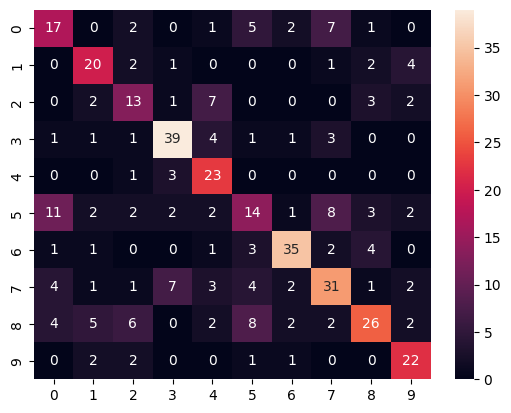

In [96]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Multinomial Logistic Regression Classifier:
Accuracy: 0.5935960591133005
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.49      0.42        35
           1       0.76      0.63      0.69        30
           2       0.43      0.54      0.48        28
           3       0.77      0.78      0.78        51
           4       0.47      0.85      0.61        27
           5       0.30      0.26      0.28        47
           6       0.86      0.79      0.82        47
           7       0.76      0.55      0.64        56
           8       0.62      0.49      0.55        57
           9       0.61      0.68      0.64        28

    accuracy                           0.59       406
   macro avg       0.60      0.61      0.59       406
weighted avg       0.61      0.59      0.60       406



<Axes: >

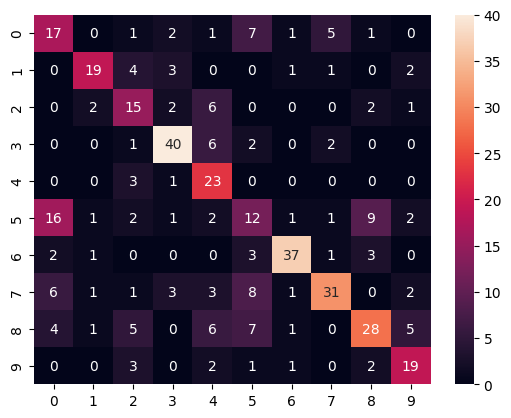

In [97]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

In [98]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Multinomial Logistic Regression Classifier:
Accuracy: 0.31527093596059114
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.34      0.34        35
           1       0.38      0.50      0.43        30
           2       0.41      0.50      0.45        28
           3       0.21      0.20      0.20        51
           4       0.19      0.37      0.25        27
           5       0.17      0.15      0.16        47
           6       0.39      0.30      0.34        47
           7       0.28      0.20      0.23        56
           8       0.62      0.40      0.49        57
           9       0.29      0.43      0.35        28

    accuracy                           0.32       406
   macro avg       0.33      0.34      0.32       406
weighted avg       0.33      0.32      0.32       406



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [99]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Multinomial Logistic Regression Classifier:
Accuracy: 0.2832512315270936
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.37      0.31        35
           1       0.38      0.53      0.44        30
           2       0.33      0.43      0.38        28
           3       0.24      0.27      0.25        51
           4       0.12      0.22      0.16        27
           5       0.09      0.04      0.06        47
           6       0.38      0.30      0.33        47
           7       0.32      0.21      0.26        56
           8       0.35      0.28      0.31        57
           9       0.36      0.36      0.36        28

    accuracy                           0.28       406
   macro avg       0.28      0.30      0.29       406
weighted avg       0.28      0.28      0.28       406



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Apply PCA and compare results

In [100]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.90)
scaler = StandardScaler()
logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

pipeline = make_pipeline(scaler, pca, logistic_regression_classifier)

pipeline.fit(X_train, y_train)

y_pred_lr = pipeline.predict(X_test)
print("Multinomial Logistic Regression Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Multinomial Logistic Regression Classifier with PCA:
Accuracy: 0.5862068965517241
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.43      0.41        35
           1       0.62      0.67      0.65        30
           2       0.47      0.54      0.50        28
           3       0.74      0.73      0.73        51
           4       0.54      0.81      0.65        27
           5       0.40      0.34      0.37        47
           6       0.79      0.72      0.76        47
           7       0.56      0.52      0.54        56
           8       0.68      0.49      0.57        57
           9       0.61      0.79      0.69        28

    accuracy                           0.59       406
   macro avg       0.58      0.60      0.58       406
weighted avg       0.59      0.59      0.58       406



In [101]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.80)
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=464)

pipeline = make_pipeline(scaler, pca, rf_classifier)

pipeline.fit(X_train, y_train)

y_pred_rf = pipeline.predict(X_test)
print("Random Forest Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier with PCA:
Accuracy: 0.27586206896551724
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.34      0.22        35
           1       0.31      0.57      0.40        30
           2       0.25      0.39      0.31        28
           3       0.36      0.39      0.38        51
           4       0.23      0.33      0.27        27
           5       0.18      0.15      0.16        47
           6       0.42      0.30      0.35        47
           7       0.23      0.12      0.16        56
           8       0.44      0.12      0.19        57
           9       0.36      0.29      0.32        28

    accuracy                           0.28       406
   macro avg       0.30      0.30      0.28       406
weighted avg       0.30      0.28      0.27       406



In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.90)
scaler = StandardScaler()
logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=42, max_iter=100)

pipeline = make_pipeline(scaler, pca, logistic_regression_classifier)

pipeline.fit(X_train, y_train)

y_pred_lr = pipeline.predict(X_test)
print("Multinomial Logistic Regression Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
